In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from torchdiffeq import odeint_adjoint as odeint
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
if torch.cuda.is_available():
    # Use GPU (CUDA)
    device = torch.device("cuda")
else:
    # Use CPU
    device = torch.device("cpu")
    
file_path = 'data.csv'  # Replace with your CSV file path
df = pd.read_csv(file_path)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
X = df.drop('Bankrupt?', axis=1)  # Predictor variables
y = df['Bankrupt?']  # Target variable

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` 

In [4]:
lasso = LogisticRegression(penalty='l1', solver='liblinear')  # L1 penalty for Lasso
lasso.fit(X_train, y_train)


LogisticRegression(penalty='l1', solver='liblinear')

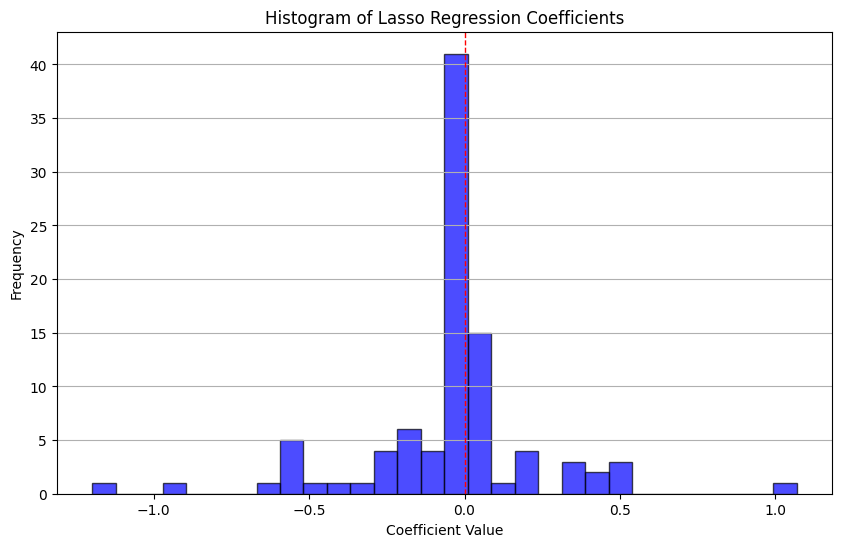

In [5]:
coefficients = pd.Series(lasso.coef_[0], index=X.columns)
# Extract coefficients
coefficients = pd.Series(lasso.coef_[0], index=X.columns)

# Plot histogram of coefficients
plt.figure(figsize=(10, 6))
plt.hist(coefficients, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Lasso Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)  # Line at zero for reference
plt.show()

In [6]:
y_pred = lasso.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the model on the test dataset: {:.2f}%".format(accuracy * 100))


Accuracy of the model on the test dataset: 96.29%


In [7]:
# Dropping insignificant features
insignificant_features = coefficients[coefficients == 0].index.tolist()
df_dropped = df.drop(columns=insignificant_features)

# Reporting number of features dropped
num_dropped = len(insignificant_features)
num_total = len(X.columns)

print(f"Dropped {num_dropped} out of {num_total} features")

Dropped 26 out of 95 features


In [8]:
# Step 1: Scale the data
scaler = StandardScaler()
X = df_dropped.drop(columns=['Bankrupt?'])
y = df_dropped['Bankrupt?']
X_scaled = scaler.fit_transform(X)

# Step 2: Extract the underrepresented class (Bankrupt? == 1)
X_scaled_minority = X_scaled[y == 1]

# Step 3: Calculate mean and std for each feature in the underrepresented class
means = X_scaled_minority.mean(axis=0)
stds = X_scaled_minority.std(axis=0)

# Step 4: Generate synthetic samples using Gaussian distribution
num_samples = 1000  # Adjust the number of samples as needed
synthetic_samples_scaled = np.random.normal(loc=means, scale=stds, size=(num_samples, X_scaled_minority.shape[1]))

# Step 5: Inverse transform the synthetic samples to the original scale
synthetic_samples_original = scaler.inverse_transform(synthetic_samples_scaled)

# Step 6: Convert synthetic samples to DataFrame and add the target column
synthetic_df = pd.DataFrame(synthetic_samples_original, columns=X.columns)
synthetic_df['Bankrupt?'] = 1  # Set target column

# Step 7: Concatenate the synthetic samples with the original data
df_augmented = pd.concat([df_dropped, synthetic_df], ignore_index=True)

/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` 

In [9]:
X = df_augmented.drop(columns=['Bankrupt?'])
y = df_augmented['Bankrupt?']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y_one_hot = torch.nn.functional.one_hot(torch.tensor(y), num_classes=2).float()
# Make predictions with the reduced feature set
X_train_dropped, X_test_dropped, y_train, y_test = train_test_split(X_scaled, y_one_hot.numpy(), test_size=0.2, random_state=42)
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_dropped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_dropped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Prepare DataLoaders
batch_size = 128  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/arataz/NDE/lib/python3.10/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` 

In [10]:
class Encoder(nn.Module):
    def __init__(self,input_dim, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = self.softplus(self.fc22(hidden))
        return z_loc, z_scale

class NeuralODE(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(NeuralODE, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()
    def forward(self, t, x):
        # Define the ODE function
        x = self.softplus(self.fc(x))  # Activation function
        return self.fc_out(x)

    def ode_solve(self, x0, t):
        # Solve the ODE using odeint
        return odeint(self, x0, t)

In [11]:
class DynVAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, input_dim, z_dim=2,ode_dim = 10, hidden_dim = 32, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(input_dim = input_dim, z_dim = z_dim , hidden_dim = hidden_dim)
        self.ode = NeuralODE(input_dim = z_dim, output_dim = 2, hidden_dim = ode_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
    # define the model p(x|z)p(z)
    def model(self, x, y):
        # register PyTorch module `decoder` with Pyro
        pyro.module("ODE", self.ode)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            t = torch.linspace(0,1,10)
            p = odeint(self.ode, z, t)
            y_hat = pyro.sample("obs", dist.OneHotCategorical(logits = p[-1,:,:]).to_event(1), obs=y)
    def guide(self, x, y):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    def get_latent_reps(self, x):
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
        return z_loc
    def predict(self, z):
        t = torch.linspace(0,1,2)
        p = odeint(self.ode, z, t)
        with pyro.plate("data", z.shape[0]):
            p = odeint(self.ode, z, t)
            pred = pyro.sample("obs", dist.OneHotCategorical(logits = p[-1,:,:]))
        return pred
            



In [12]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x, y)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train
def validate(model, test_loader, use_cuda = False):
    accuracies = []
    for x,y in test_loader:
        x = x.cuda()
        y = y.cuda()
        z = model.get_latent_reps(x)
        y_hat = model.predict(z)
        # Convert one-hot encoded to class labels
        predicted_classes = torch.argmax(y_hat, dim=1)
        true_classes = torch.argmax(y, dim=1)

        # Calculate accuracy
        acc = (predicted_classes == true_classes).float().mean()
        accuracies.append(acc.detach().cpu().numpy())
    return np.mean(accuracies)

In [13]:
pyro.clear_param_store()
USE_CUDA = True
dynvae = DynVAE(input_dim = X_train_tensor.shape[-1], use_cuda = USE_CUDA)
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(dynvae.model, dynvae.guide, optimizer, loss=Trace_ELBO())
train_elbo = []
test_acc = []
NUM_EPOCHS = 100
TEST_FREQUENCY = 5
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:

        # report test diagnostics
        total_epoch_acc_test = validate(dynvae, test_loader, use_cuda=USE_CUDA)
        test_acc.append(total_epoch_acc_test)
        print("[epoch %03d] average test accuracy: %.4f" % (epoch, total_epoch_acc_test))

/home/arataz/NDE/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


[epoch 000]  average training loss: 65.8398
[epoch 000] average test accuracy: 0.7900
[epoch 001]  average training loss: 34.7648
[epoch 002]  average training loss: 30.8653
[epoch 003]  average training loss: 28.8042
[epoch 004]  average training loss: 27.4189
[epoch 005]  average training loss: 26.5944
[epoch 005] average test accuracy: 0.8899
[epoch 006]  average training loss: 25.5927
[epoch 007]  average training loss: 24.7021
[epoch 008]  average training loss: 24.4802
[epoch 009]  average training loss: 23.0833
[epoch 010]  average training loss: 22.1625
[epoch 010] average test accuracy: 0.9176
[epoch 011]  average training loss: 21.5187
[epoch 012]  average training loss: 20.6040
[epoch 013]  average training loss: 19.7747
[epoch 014]  average training loss: 18.6626
[epoch 015]  average training loss: 18.0096
[epoch 015] average test accuracy: 0.9344
[epoch 016]  average training loss: 16.7310
[epoch 017]  average training loss: 16.0605
[epoch 018]  average training loss: 15.8

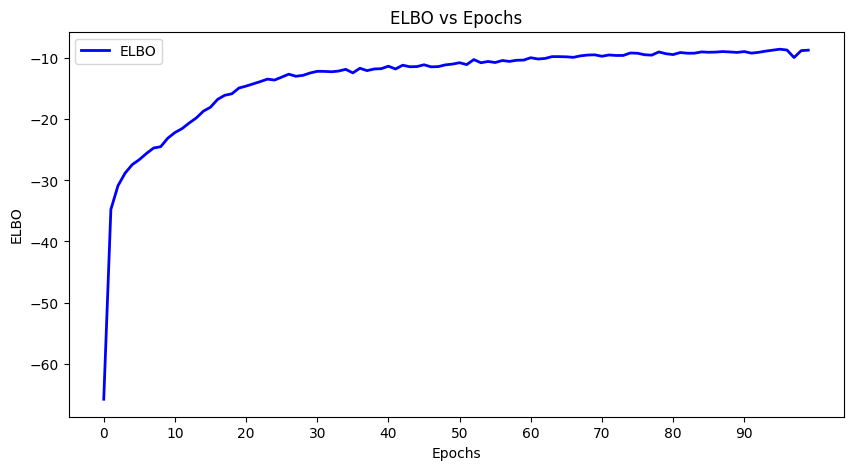

In [14]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_EPOCHS), train_elbo, label='ELBO', color='blue', linewidth=2)
plt.title('ELBO vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.xticks(range(0, NUM_EPOCHS, 10))  # Set x-ticks every 10 epochs
plt.legend()
plt.show()

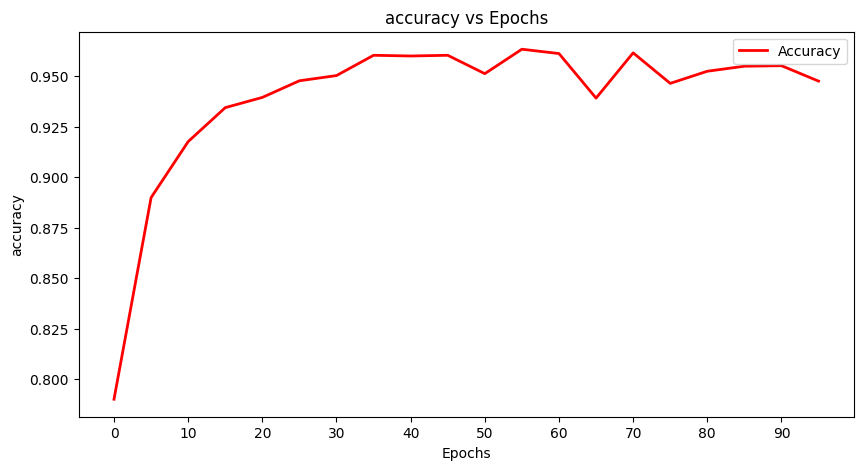

In [15]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0,NUM_EPOCHS,5), test_acc, label='Accuracy', color='red', linewidth=2)
plt.title('accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.xticks(range(0, NUM_EPOCHS, 10))  # Set x-ticks every 10 epochs
plt.legend()
plt.show()

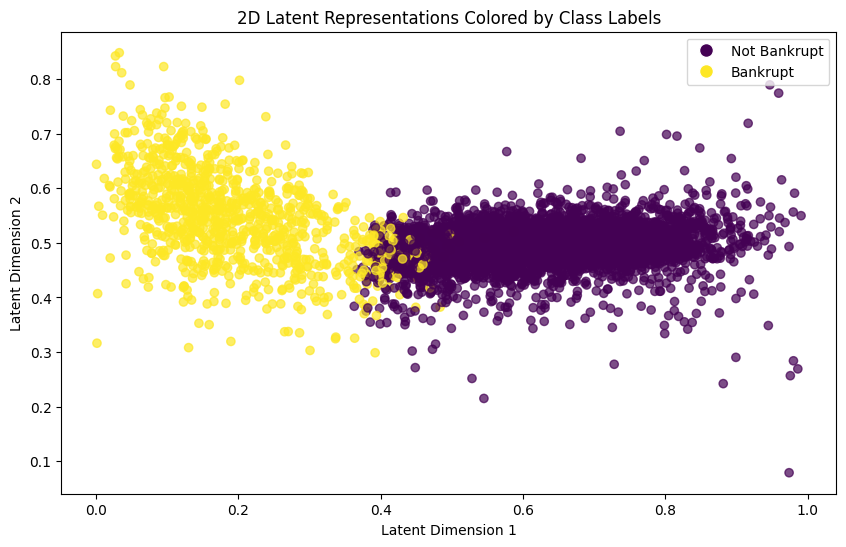

In [21]:
sigmoid = nn.Sigmoid()
latent_reps = sigmoid(dynvae.get_latent_reps(X_train_tensor.to(device))).detach().cpu().numpy()
label = np.argmax(y_train_tensor, axis=1)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Create scatter plot with numeric labels
scatter = plt.scatter(latent_reps[:, 0], latent_reps[:, 1], 
                     c=label, 
                     cmap='viridis', 
                     alpha=0.7)

# Create custom legend handles
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=scatter.cmap(scatter.norm(0)), 
                            label='Not Bankrupt', markersize=10),
                  plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=scatter.cmap(scatter.norm(1)), 
                            label='Bankrupt', markersize=10)]

# Add titles and labels
plt.title('2D Latent Representations Colored by Class Labels')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

# Add the custom legend
plt.legend(handles=legend_elements)
plt.show()

/tmp/ipykernel_124165/4036410259.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


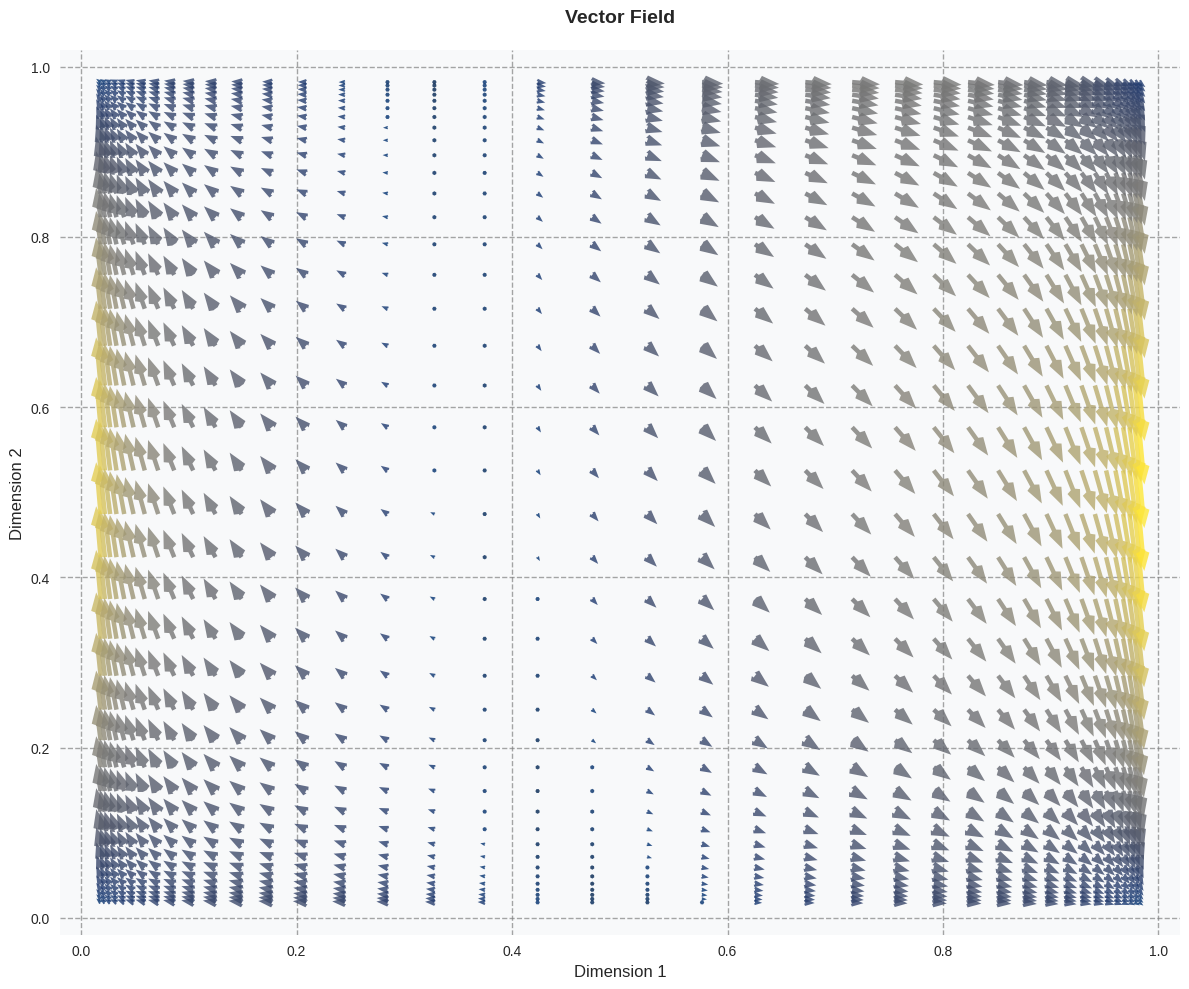

In [55]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_transformed_vector_field(dynvae, grid_size=40):
    # Create grid of untransformed points between -5 and 5
    x = np.linspace(-4, 4, grid_size)
    y = np.linspace(-4, 4, grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Reshape grid points into a list of 2D points
    grid_points = np.stack([X.flatten(), Y.flatten()], axis=1)
    
    # Convert to tensor
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)
    
    # Calculate vector field on untransformed points
    velocities = dynvae.ode(t=None, x=grid_tensor).detach().cpu().numpy()
    
    # Calculate sigmoid of input points
    sigmoid_points = sigmoid(grid_points)
    
    # Calculate sigmoid derivative at each point
    sigmoid_derivative = sigmoid(grid_points) * (1 - sigmoid(grid_points))
    
    # Transform velocities
    transformed_velocities = velocities * sigmoid_derivative
    
    # Reshape back to grid
    U = transformed_velocities[:, 0].reshape(grid_size, grid_size)
    V = transformed_velocities[:, 1].reshape(grid_size, grid_size)
    
    # Get transformed grid points
    X_transformed = sigmoid_points[:, 0].reshape(grid_size, grid_size)
    Y_transformed = sigmoid_points[:, 1].reshape(grid_size, grid_size)
    
    # Calculate vector magnitudes for coloring
    magnitudes = np.sqrt(U**2 + V**2)
    
    # Create figure with a specific background color
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
    ax.set_facecolor('#f8f9fa')
    
    # Plot the vector field
    quiver = ax.quiver(X_transformed, Y_transformed, U, V,
                      magnitudes,  # Color arrows by magnitude
                      cmap='cividis',  # Use a pleasant colormap
                      alpha=0.8,    # Slight transparency
                      scale=30,     # Adjust arrow scale
                      width=0.004,  # Make arrows thinner
                      headwidth=3,  # Adjust arrow head width
                      headlength=4, # Adjust arrow head length
                      headaxislength=4.5)

    
    # Set limits with some padding
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)
    
    # Customize grid
    ax.grid(True, linestyle='--', alpha=0.7, color='gray')
    
    # Add labels and title with nice fonts
    plt.xlabel('Dimension 1', fontsize=12, fontweight='medium')
    plt.ylabel('Dimension 2', fontsize=12, fontweight='medium')
    plt.title('Vector Field', 
              fontsize=14, 
              fontweight='bold', 
              pad=20)
    
    # Add subtle box around the plot
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_color('#cccccc')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


# Usage:
plot_transformed_vector_field(dynvae)

In [356]:
# Propagate trajectories to see the outcomes
dynvae.eval()
t = torch.linspace(0,2,150)
z = dynvae.get_latent_reps(X_test_tensor.to(device)).detach()
y_hat = odeint(dynvae.ode,z,t)

/home/arataz/NDE/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


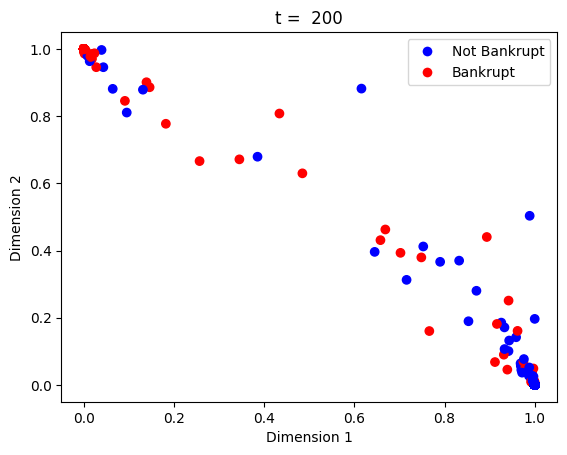

In [358]:
import matplotlib.animation as animation

# Assuming y_hat is a tensor of shape [frames, data_length, 2]
# And label is a tensor of shape [data_length] with binary values (0 or 1)
frames, data_length, _ = y_hat.shape

# Convert y_hat to numpy for compatibility with matplotlib
y_hat_np = torch.nn.functional.sigmoid(y_hat).detach().cpu().numpy()
label = np.argmax(y_test, axis=1)


# Set up figure for plotting
fig, ax = plt.subplots()
colors = ['blue', 'red']  # 0: 'blue' (not bankrupt), 1: 'red' (bankrupt)

def update(frame):
    ax.clear()
    # Scatter plot of the current frame
    ax.scatter(y_hat_np[frame, :, 0], y_hat_np[frame, :, 1], 
               c=[colors[int(lbl)] for lbl in label],
               label=['Not Bankrupt', 'Bankrupt'])
    
    # Add labels and title
    ax.set_title(f't =  {int(4*(frame + 1)/3)}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8) 
                       for color in colors], 
              labels=['Not Bankrupt', 'Bankrupt'])

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=frames, interval=200)

# Save the animation
ani.save('scatter_animation.gif', writer='imagemagick')
plt.show()

In [360]:
x_bankrupt = X_test_tensor[11].to(device)
latent_rep = dynvae.get_latent_reps(x_bankrupt)
t = torch.linspace(0,2,500)
y_hat = odeint(dynvae.ode,latent_rep,t)

/home/arataz/NDE/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


In [361]:
x_bankrupt[4] += 0.3
x_bankrupt[9] += 0.3
x_bankrupt[11] += 0.3
x_bankrupt[13] += 0.3
x_bankrupt[18] += 0.3
perturbed_latent_rep = dynvae.get_latent_reps(x_bankrupt)
t = torch.linspace(0,2,500)
perturbed_y_hat = odeint(dynvae.ode,perturbed_latent_rep,t)
perturbed_y_hat[0] = latent_rep

In [362]:
perturbed_y_hat = torch.nn.functional.sigmoid(perturbed_y_hat).detach().cpu().numpy()
y_hat = torch.nn.functional.sigmoid(y_hat).detach().cpu().numpy()

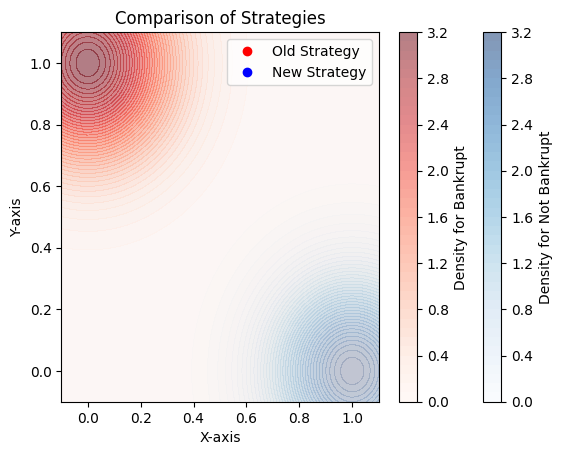

/tmp/ipykernel_259384/1543634591.py:51: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line1.set_data(y_hat[frame, 0], y_hat[frame, 1])  # Update old strategy
/tmp/ipykernel_259384/1543634591.py:52: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line2.set_data(perturbed_y_hat[frame, 0], perturbed_y_hat[frame, 1])  # Update new strategy


In [363]:
# Create a grid for heatmap
x = np.linspace(-0.1, 1.1, 100)
y = np.linspace(-0.1, 1.1, 100)
X, Y = np.meshgrid(x, y)

# Define points for heatmaps
pos_not_bankrupt = (1, 0)  # Not bankrupt
pos_bankrupt = (0, 1)      # Bankrupt

# Define covariance for both distributions
cov = [[0.05, 0], [0, 0.05]]  # Small covariance for tight peaks

# Create Gaussian distributions for the two points
rv_not_bankrupt = multivariate_normal(mean=pos_not_bankrupt, cov=cov)
rv_bankrupt = multivariate_normal(mean=pos_bankrupt, cov=cov)

# Calculate the probability density function values on the grid
Z_not_bankrupt = rv_not_bankrupt.pdf(np.dstack((X, Y)))
Z_bankrupt = rv_bankrupt.pdf(np.dstack((X, Y)))

# Create a figure and axis
fig, ax = plt.subplots()

# Use different colormaps for each region
heatmap1 = ax.contourf(X, Y, Z_not_bankrupt, levels=50, cmap='Blues', alpha=0.5)
heatmap2 = ax.contourf(X, Y, Z_bankrupt, levels=50, cmap='Reds', alpha=0.5)

line1, = ax.plot([], [], 'ro', label='Old Strategy')  # Blue dots for y_hat
line2, = ax.plot([], [], 'bo', label='New Strategy')  # Red dots for perturbed_y_hat
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_title('Comparison of Strategies')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.legend()

# Add a color bar for the heatmaps
cbar1 = plt.colorbar(heatmap1, ax=ax)
cbar1.set_label('Density for Not Bankrupt')
cbar2 = plt.colorbar(heatmap2, ax=ax)
cbar2.set_label('Density for Bankrupt')

# Initialization function for FuncAnimation
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

# Animation function
def update(frame):
    line1.set_data(y_hat[frame, 0], y_hat[frame, 1])  # Update old strategy
    line2.set_data(perturbed_y_hat[frame, 0], perturbed_y_hat[frame, 1])  # Update new strategy
    return line1, line2

# Create the animation
ani = FuncAnimation(fig, update, frames=range(500), init_func=init, blit=True, repeat=False)

# Show the animation
plt.show()

# Save the animation as a GIF
ani.save('comparison_animation_with_distinct_heatmaps.gif', writer='pillow', fps = 50)